In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [4]:
def normalize_angle(angle):
    while (angle > math.pi):
        angle = angle - 2*math.pi
    while (angle < -math.pi):
        angle = angle + 2*math.pi
    return angle


class MotionModel:
    def __init__(self, pose):
        self.pose = np.copy(pose)   
        
    @property
    def pose(self):
        return self.pose
    
    @pose.setter
    def pose(self, new_pose):
        self.pose = np.copy(new_pose)
    
    @pose.deleter
    def pose(self):
        self.pose = None
        del self.pose
        
    def motion_command(self, command):
        rot1 = command[0]
        trans = command[1]
        rot2 = command[2]
        
        theta_old = normalize_angle(self.pose.item(2))
        
        update_vec = np.matrix([
            trans*math.cos(theta_old + rot1),
            trans*math.sin(theta_old + rot1),
            rot1 + rot2
        ]).T
        
        self.pose = self.pose + update_vec
        
        return self.pose

        
class BaseRobot:
    def __init__(self, x, y, theta, motion_model=None):
        self.pose = np.matrix([x, y, theta]).T
        self.motion = motion_model
    
    @property
    def pose(self):
        return self.pose
    
    @pose.setter
    def pose(self, new_pose):
        self.pose = np.copy(new_pose)
    
    @pose.deleter
    def pose(self):
        self.pose = None
        del self.pose
    
    @property
    def motion(self):
        return self.motion
    
    @motion.setter
    def motion(self, motion_model):
        self.motion = motion_model
    
    @motion.deleter
    def motion(self):
        del self.motion
        
    def motion_command(self, command):
        self.pose = self.motion.motion_command(command)

In [5]:
def read_data(filename):
    odometry = []
    sensor = []
    
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split(" ")
        
            if data[0] == "ODOMETRY":
                # rotation1, translation, rotation2
                data[1:] = [float(d) for d in data[1:]]
                odometry.append(tuple(data[1:]))
            elif data[0] == "SENSOR":
                # id
                data[1] = int(data[1])
                # range, bearing
                data[2:] = [float(d) for d in data[2:]]
                
                sensor.append(tuple(data[1:]))
    
    return odometry, sensor

In [6]:
def read_world(filename):
    landmarks = []
    
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split(" ")
            data[0] = int(data[0])
            data[1:] = [float(d) for d in data[1:]]
            
            landmarks.append(tuple(data))
    
    return landmarks

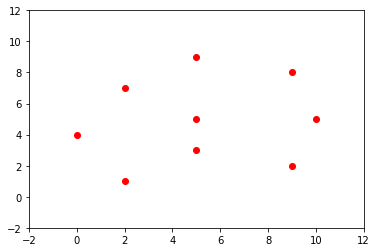

In [16]:
robot = BaseRobot(0, 0, 0)
motion_model = MotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_data('./data/simple/sensor_data.dat')
landmarks = read_world('./data/simple/world.dat')

commands = [np.array(odom).T for odom in odometry]

x = []
y = []

fig, ax = plt.subplots()

ax.set_xlim((-2, 12))
ax.set_ylim((-2, 12))

ln, = ax.plot([], [])


for landmark in landmarks:
    ax.plot(landmark[1], landmark[2], 'ro')

def init():
    ln.set_data([], [])
    return ln,

def update(frame):
    robot.motion_command(frame)
    
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    ln.set_data(x, y)
    
    return ln,

ani = FuncAnimation(fig, update, frames=commands, init_func=init, blit=True)

In [17]:
HTML(ani.to_html5_video())